In [1]:
# | echo: false
%load_ext autoreload
%autoreload 2

## Setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from jaxcmr_research.state_analysis import matrix_heatmap, instance_memory_heatmap
from jax import numpy as jnp, lax

# from jaxcmr_research.models.cmr.no_reinstate_cmr import BaseCMR, InstanceCMR
from jaxcmr_research.models.cmr.cmr import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.weirdcmr import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.flexcmr import BaseCMR, InstanceCMR

# from jaxcmr_research.models.cmr._cmr import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.trace_reinstatement_cmr import CMR as InstanceCMR
# from jaxcmr_research.models.cmr.weirdcmrde import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.contextcmrde import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.multicontextcmrde import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.mcf_multiplex_cmr import BaseCMR, InstanceCMR
# from jaxcmr_research.models.cmr.contextcmrde3 import BaseCMR, InstanceCMR
from jaxcmr_research.models.cmr.positional_cmr import BaseCMR, InstanceCMR
import json

fit_result_path = (
    # "results/icmr/Model_Fitting/HealyKahana2014_ScaleFreeBaseCMR_Model_Fitting.json"
    "notebooks/Model_Fitting//fits//LohnasKahana2014_ConnectionistCMR_Model_Fitting.json"
    # "notebooks/Model_Fitting/fits/KahanaJacobs2000_BaseCMR_Model_Fitting.json"
)

with open(fit_result_path, "r") as f:
    fit_result = json.load(f)

base_params = {key: jnp.array(value[2]) for key, value in fit_result["fits"].items()}
base_params["mfc_trace_sensitivity"] = jnp.array(.1, dtype=jnp.float32)
base_params

{'encoding_drift_rate': Array(0.7979755, dtype=float32, weak_type=True),
 'start_drift_rate': Array(0.11902849, dtype=float32, weak_type=True),
 'recall_drift_rate': Array(0.9213753, dtype=float32, weak_type=True),
 'shared_support': Array(0.05847341, dtype=float32, weak_type=True),
 'item_support': Array(0.6875884, dtype=float32, weak_type=True),
 'learning_rate': Array(0.3528511, dtype=float32, weak_type=True),
 'primacy_scale': Array(7.2920995, dtype=float32, weak_type=True),
 'primacy_decay': Array(0.53475994, dtype=float32, weak_type=True),
 'stop_probability_scale': Array(0.00748838, dtype=float32, weak_type=True),
 'stop_probability_growth': Array(0.14557873, dtype=float32, weak_type=True),
 'choice_sensitivity': Array(1.2927668, dtype=float32, weak_type=True),
 'mcf_trace_sensitivity': Array(1., dtype=float32, weak_type=True),
 'mfc_trace_sensitivity': Array(0.1, dtype=float32),
 'mfc_choice_sensitivity': Array(1., dtype=float32, weak_type=True),
 'semantic_scale': Array(0., dt

## Memory Array Visualization

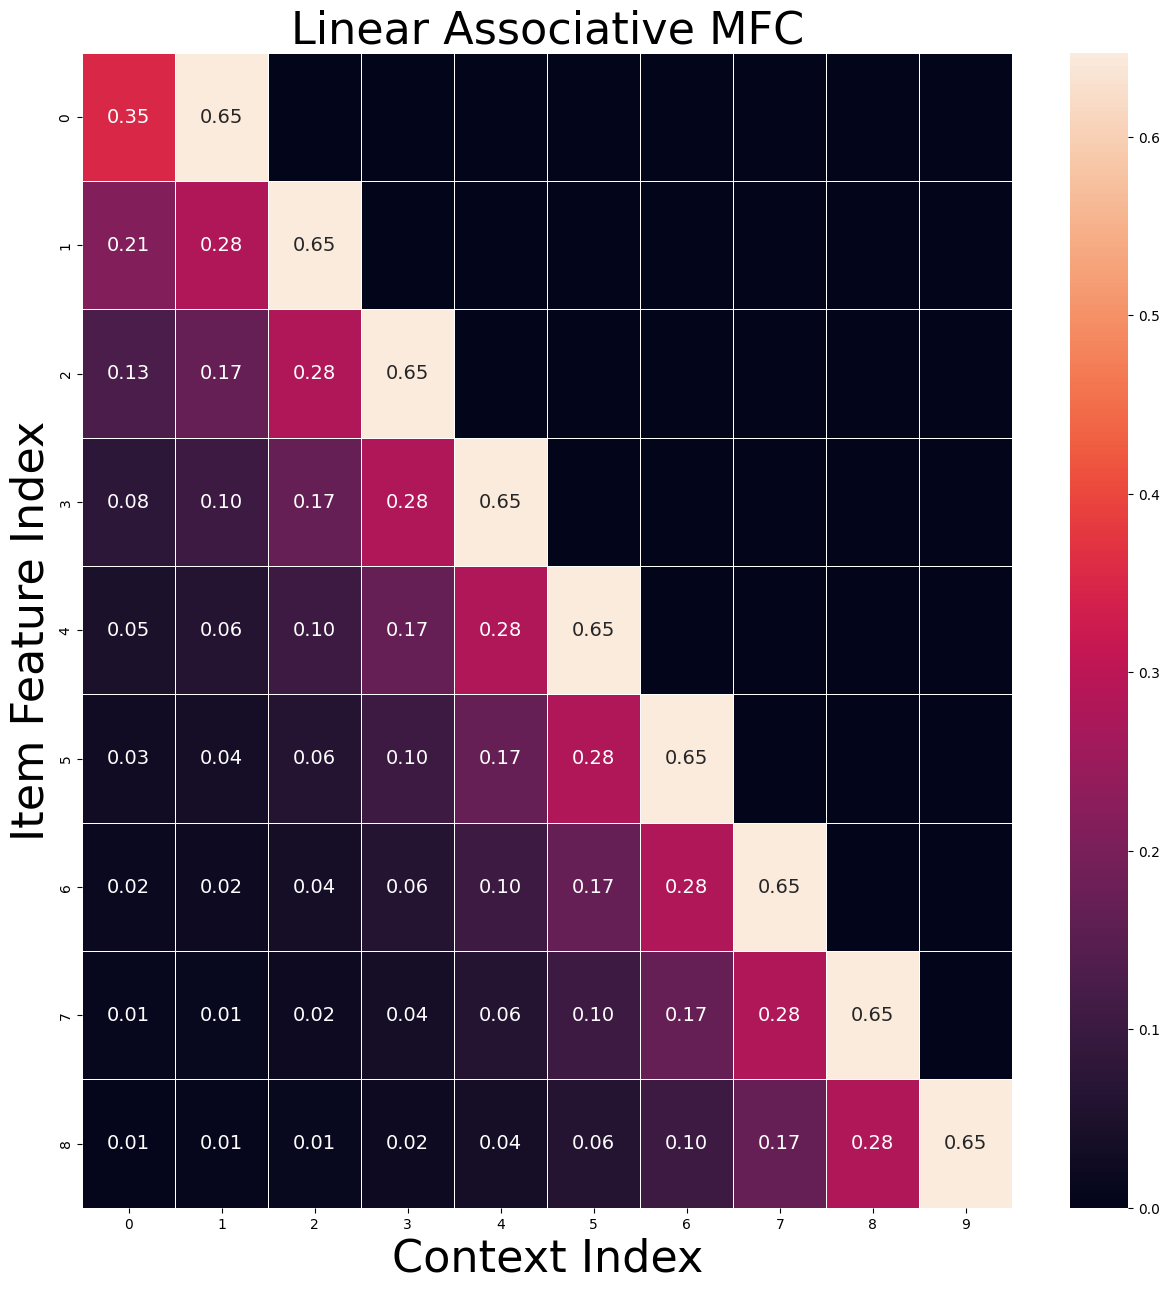

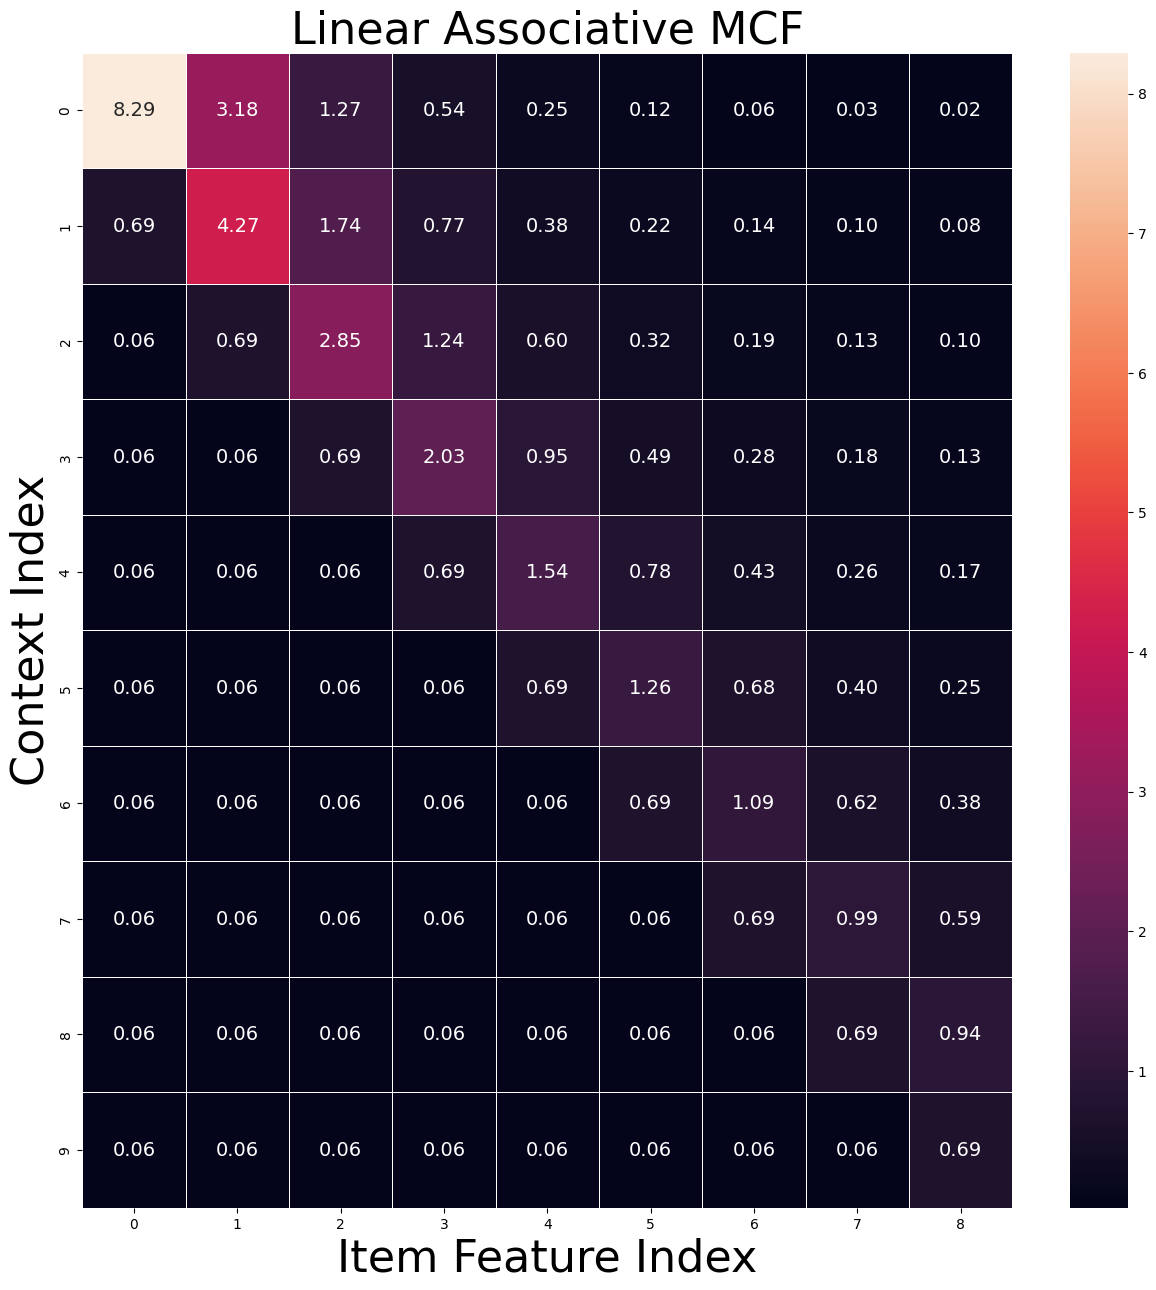

In [ ]:
#| code-summary: linear memory using the model and a study list with one item repetition (positions 2, 7; item 2)
model_create_fn = BaseCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(model.mfc.state, title="Linear Associative MFC")
plt.xlabel("Context Index")
plt.ylabel("Item Feature Index")
plt.show()

matrix_heatmap(model.mcf.state, title="Linear Associative MCF")
plt.xlabel("Item Feature Index")
plt.ylabel("Context Index")
plt.show()

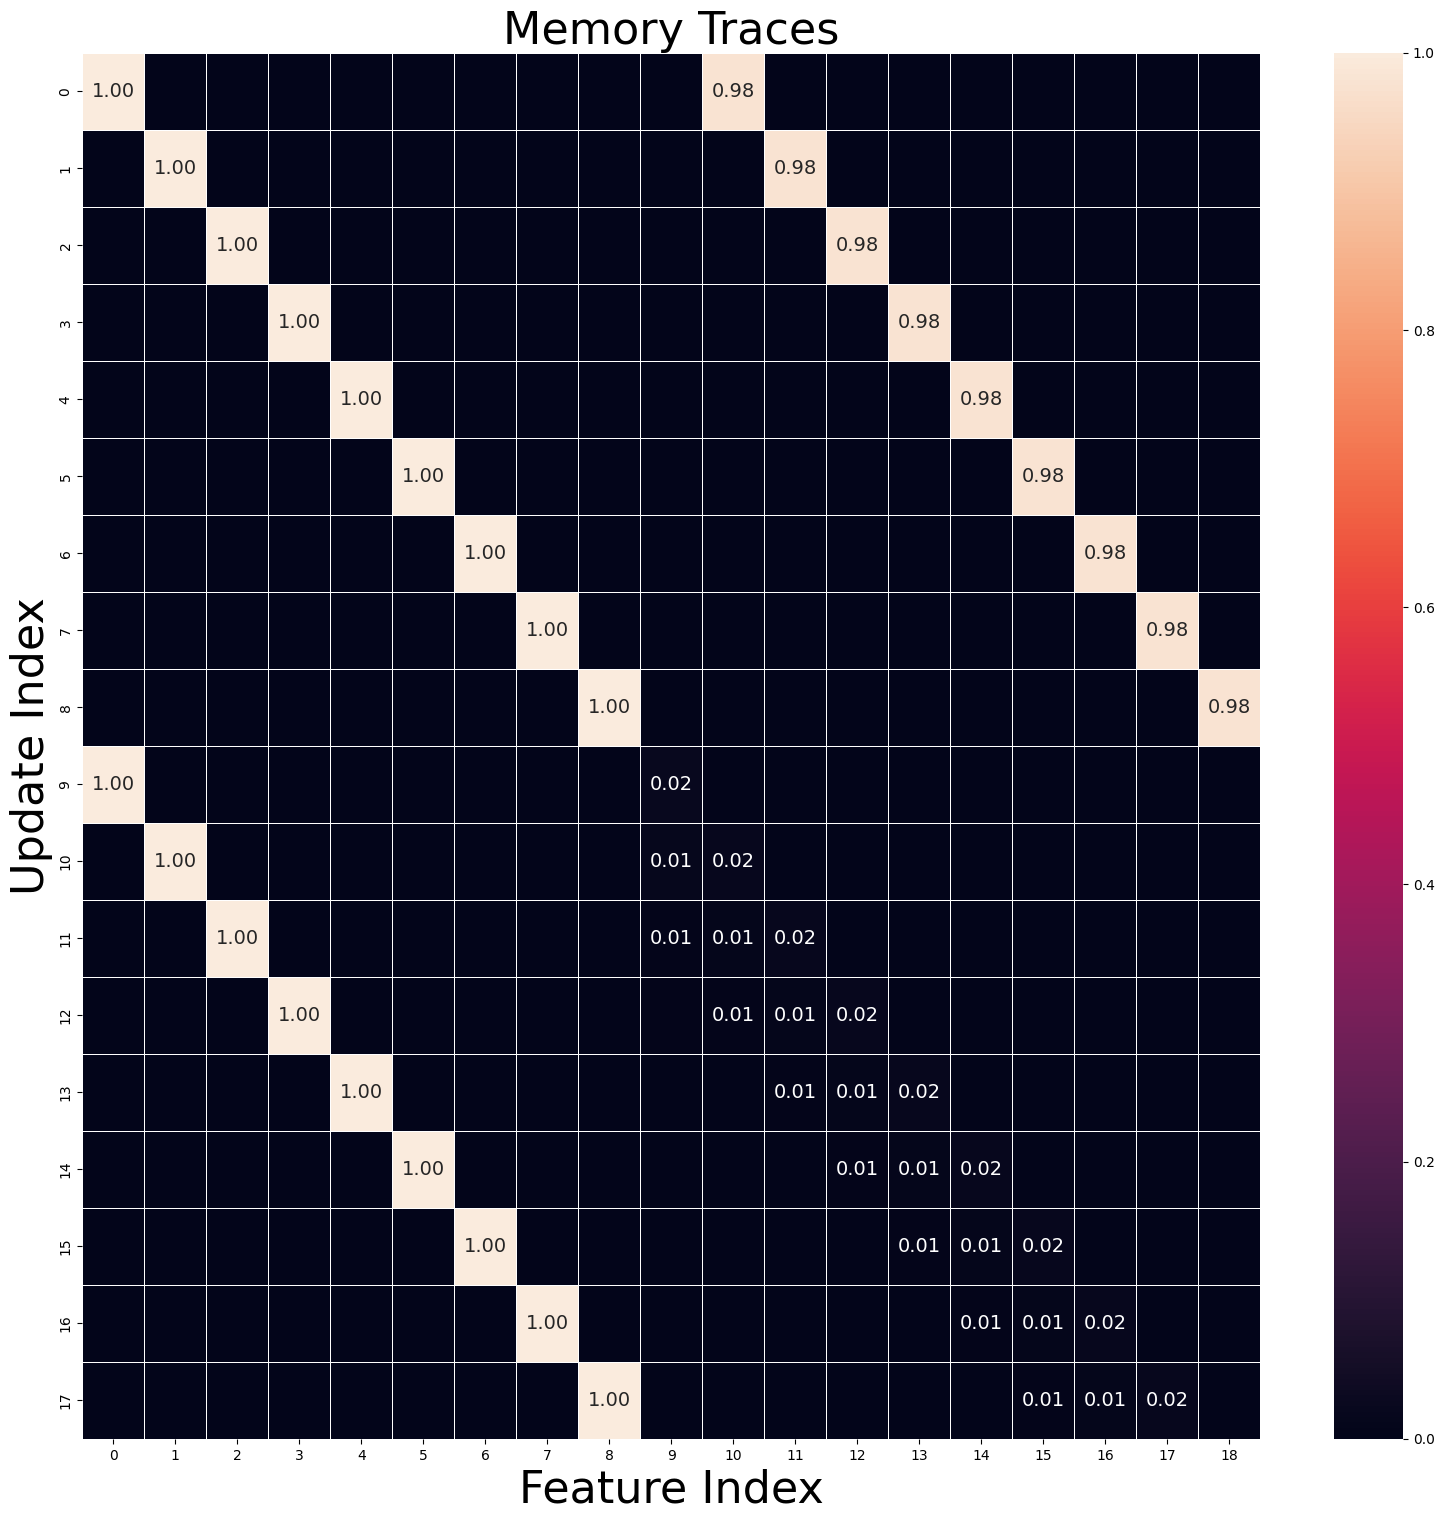

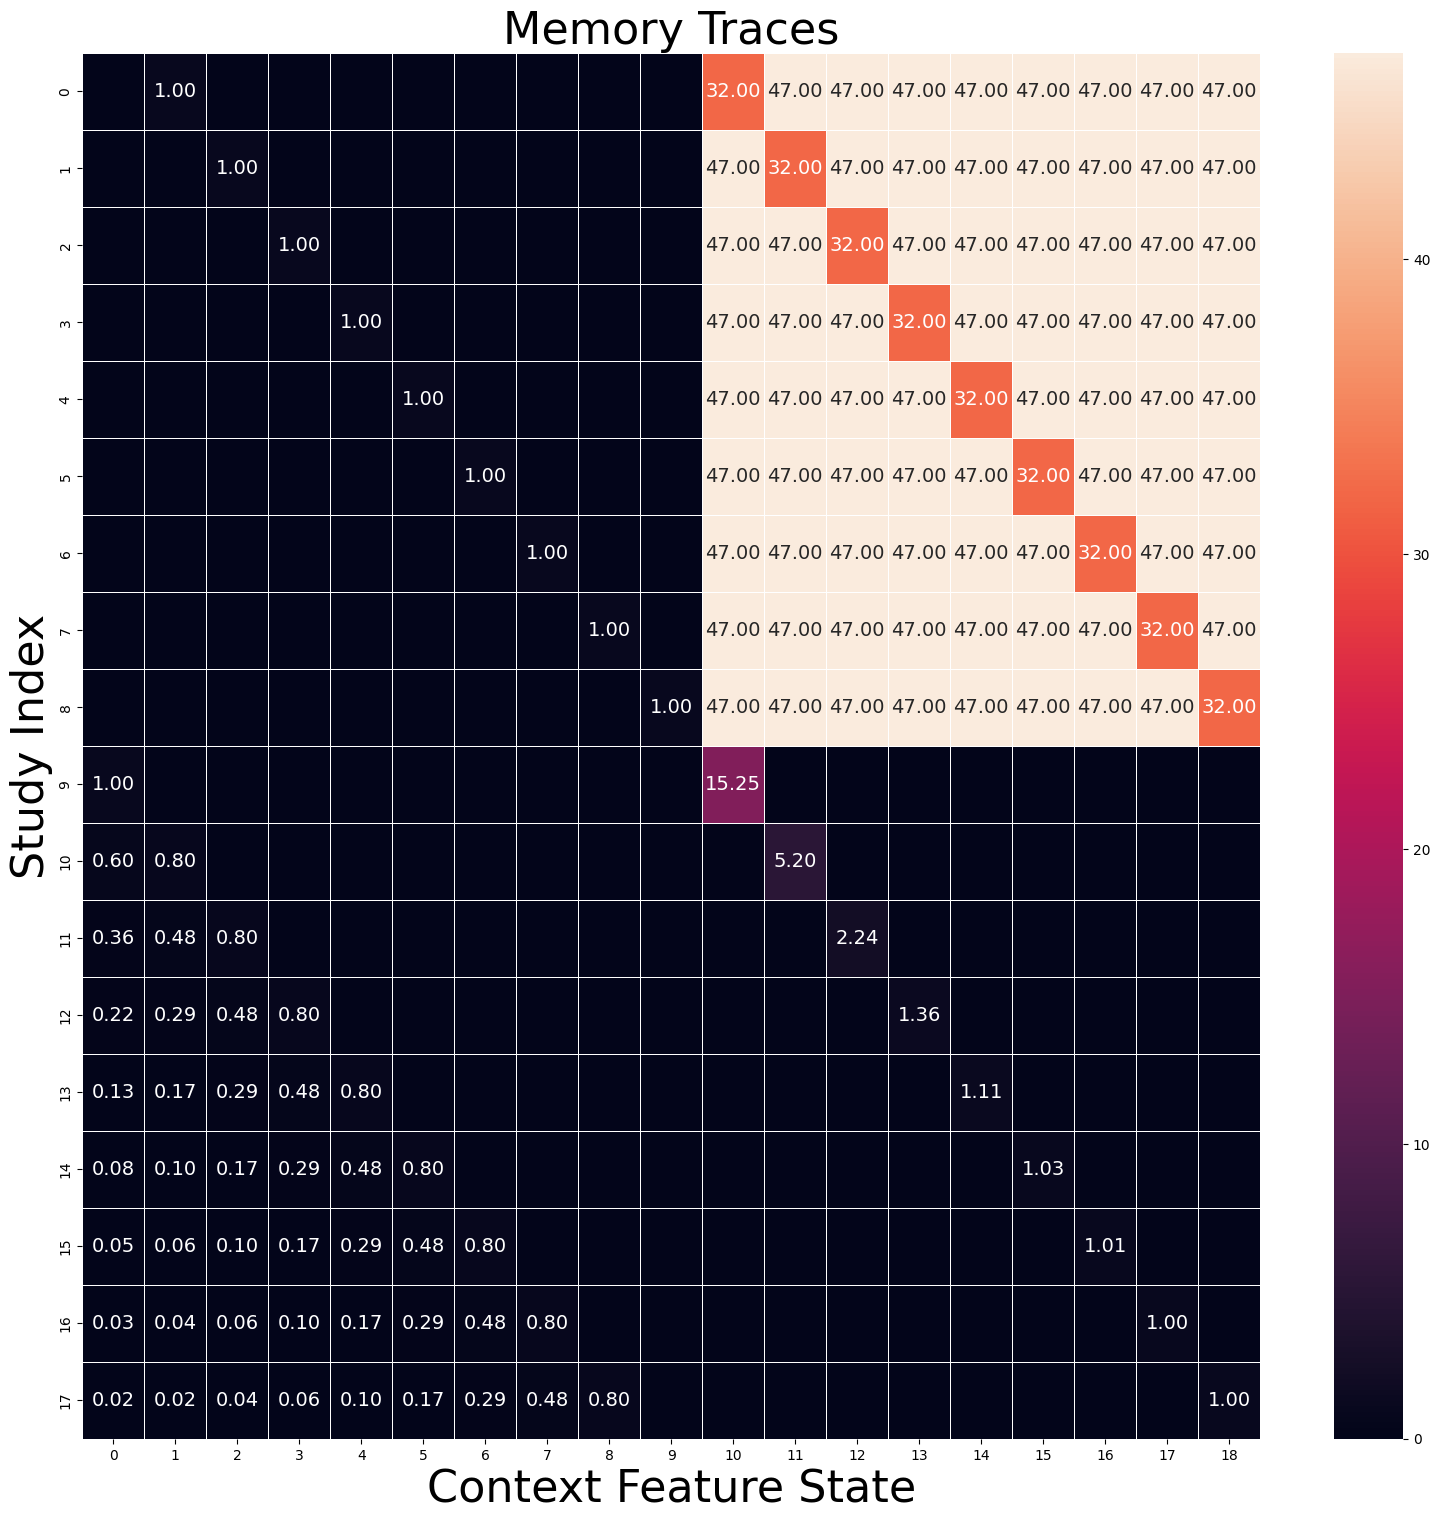

In [13]:
#| code-summary: instance memory using the model and a study list with one item repetition (positions 2, 7; item 2)

model_create_fn = InstanceCMR
list_length = 9
item_count = 8

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

instance_memory_heatmap(
    model.mfc.state,
    list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.show()


instance_memory_heatmap(
    model.mcf.state,
    list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.ylabel("Study Index")
plt.xlabel("Context Feature State")
plt.savefig("context_states.pdf", bbox_inches="tight")
plt.show()


In [ ]:
#| code-summary: setup an analysis of recall activations/probabilities in the model as fn of parameter manipulation

from jaxcmr_research.helpers.math import linalg_norm

# parametrization
model_create_fn = InstanceCMR
list_length = 8
item_count = 8

# study events and set up for recall
present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

# simulate retrieval of repeated item
item_index = 2
first_encoding_index = 1
second_encoding_index = 6 #! normally 6, but when we multiplex traces is 7
# model = model.retrieve(6)
print(model.context.state)
model = model.retrieve(1)
model = model.retrieve(item_index)
print(model.context.state)
print(jnp.round(model.outcome_probabilities(), 2))
print(len(model.outcome_probabilities() * 100))
print(model.recalls)

[0.13599797 0.02283806 0.03789355 0.06287403 0.10432234 0.17309454
 0.28720325 0.47653568 0.7906813 ]
[0.33414313 0.43191624 0.614561   0.04964866 0.08231097 0.13626722
 0.22473796 0.4839469  0.10766   ]
[0.01       0.         0.         0.48999998 0.19999999 0.11
 0.09       0.11       0.        ]
9
[1 2 0 0 0 0 0 0]


In [9]:
model_create_fn = InstanceCMR
list_length = 8
item_count = 8
present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])

probabilities = []

# base_params = {key: jnp.array(value[2]) for key, value in fit_result["fits"].items()}
subject_count = len(fit_result["fits"]['encoding_drift_rate'])

for i in range(subject_count):
    parameters = {key: jnp.array(value[i]) for key, value in fit_result["fits"].items()}
    parameters['learning_rate'] = jnp.array(0.02, dtype=jnp.float32)
    parameters['item_support'] = jnp.array(32, dtype=jnp.float32)
    parameters['shared_support'] = jnp.array(47, dtype=jnp.float32)
    parameters['choice_sensitivity'] = jnp.array(90., dtype=jnp.float32)
    model = model_create_fn(list_length, parameters)
    model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
    model = model.start_retrieving()
    model = model.retrieve(1)
    model = model.retrieve(2)
    probabilities.append(model.outcome_probabilities())

probabilities = jnp.array(probabilities)
print(probabilities.shape)


(35, 9)


In [10]:
probabilities.mean(0)

Array([0.02495136, 0.        , 0.        , 0.590614  , 0.15842247,
       0.10189691, 0.07486157, 0.04925367, 0.        ], dtype=float32)

In [11]:
inputs = []

# mcf_in_pattern = model.mfc.full_probe(model.items[1], model.context.state)
mcf_in_pattern = model.mfc.probe(model.items[1])
mcf_in_pattern = linalg_norm(mcf_in_pattern)
inputs.append(mcf_in_pattern)

mcf_in_pattern = (
    model.mcf.state[list_length + first_encoding_index][: model.mcf.input_size]
    + model.mcf.state[list_length + second_encoding_index][: model.mcf.input_size]
)

mcf_in_pattern = linalg_norm(mcf_in_pattern)
inputs.append(mcf_in_pattern)

mcf_in_pattern = model.mcf.state[list_length + first_encoding_index][
    : model.mcf.input_size
]
mcf_in_pattern = linalg_norm(mcf_in_pattern)
inputs.append(mcf_in_pattern)

mcf_in_pattern = model.mcf.state[list_length + second_encoding_index][
    : model.mcf.input_size
]
mcf_in_pattern = linalg_norm(mcf_in_pattern)
inputs.append(mcf_in_pattern)

for mcf_in_pattern in inputs:
    print(mcf_in_pattern)

[0.01222606 0.01633533 0.99979174 0.         0.         0.
 0.         0.         0.        ]
[0.43975928 0.58756596 0.07031281 0.11734418 0.19583417 0.32682517
 0.54543436 0.         0.        ]
[0.5992016 0.8005981 0.        0.        0.        0.        0.
 0.        0.       ]
[0.04628476 0.06184144 0.10320637 0.17223983 0.28744882 0.4797197
 0.8005981  0.         0.        ]


[0.         0.         1.         0.1200578  0.06350579 0.04859349
 0.         0.03896853]
1.2711257
[0.0000000e+00 0.0000000e+00 3.0126076e-02 4.7162743e-03 5.0487008e-04
 1.4132342e-05 0.0000000e+00 9.3709692e-02]
0.12907106
[0.0000000e+00 0.0000000e+00 2.0354561e-04 2.7907896e-05 1.5371837e-05
 1.1964888e-05 0.0000000e+00 9.7316342e-06]
0.00026852186
[0.0000000e+00 0.0000000e+00 3.5227165e-02 5.8508264e-03 2.9886872e-04
 1.7513325e-06 0.0000000e+00 6.6566670e-01]
0.7070454
[[0.0000000e+00 0.0000000e+00 7.8670430e-01 9.4449982e-02 4.9960278e-02
  3.8228706e-02 0.0000000e+00 3.0656712e-02]
 [0.0000000e+00 0.0000000e+00 2.3340690e-01 3.6540139e-02 3.9115669e-03
  1.0949272e-04 0.0000000e+00 7.2603178e-01]
 [0.0000000e+00 0.0000000e+00 7.5802249e-01 1.0393156e-01 5.7246130e-02
  4.4558335e-02 0.0000000e+00 3.6241498e-02]
 [0.0000000e+00 0.0000000e+00 4.9823061e-02 8.2750367e-03 4.2270089e-04
  2.4769733e-06 0.0000000e+00 9.4147664e-01]]


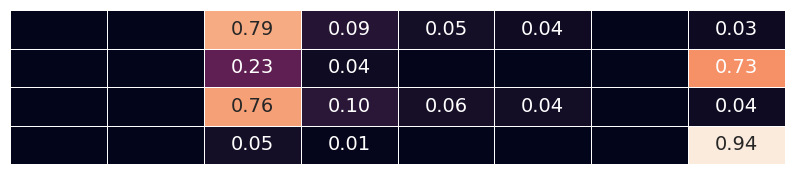

In [12]:
activations = []

for mcf_in_pattern in inputs:
    activation = model.mcf.probe(mcf_in_pattern) * model.recallable
    print(activation)
    print(activation.sum())
    activation = activation / activation.sum()
    activations.append(activation[:8])

recall_supports = jnp.array(activations)

print(recall_supports)
matrix_heatmap(recall_supports, figsize=(10, 2))
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

# remove the colorbar
axis = plt.gca()
# remove the colorbar
cax = axis.collections[0].colorbar
cax.remove()

plt.savefig("trace_supports.pdf", bbox_inches="tight")

Text(95.72222222222221, 0.5, '')

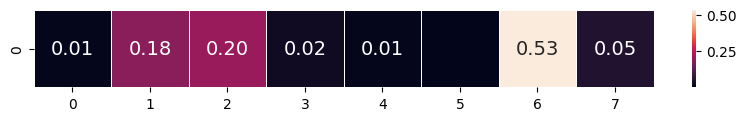

In [ ]:
recall_supports = activation / activation.sum()

# add dimension to make 1xN matrix
recall_supports = recall_supports[:8][None, :]

matrix_heatmap(recall_supports, figsize=(10, 1))
plt.xlabel("")
plt.ylabel("")

## Trace Reinstatement

In [8]:
repetition_sensitivity = 5

mfc_in_pattern = model.items[item_index]
mfc_input = model.mfc._probe.at[: mfc_in_pattern.size].set(mfc_in_pattern)
mfc_t = model.mfc.trace_activations(mfc_input)

mcf_in_pattern = model.context.state
mcf_input = model.mcf._probe.at[: mcf_in_pattern.size].set(mcf_in_pattern)
mcf_t = model.mcf.trace_activations(mcf_input)

base_t = mfc_t.at[mfc_in_pattern.size :].multiply(mcf_t[mfc_in_pattern.size :])
base_t = base_t.at[mfc_in_pattern.size :].power(repetition_sensitivity)
scaling_factor = (
    mfc_t[mfc_in_pattern.size :].sum() / base_t[mfc_in_pattern.size :].sum()
)
t = base_t.at[mfc_in_pattern.size :].multiply(scaling_factor)

linalg_norm(jnp.dot(t, model.mfc.state)[mfc_in_pattern.size :])

ValueError: Incompatible shapes for broadcasting: (18,) and requested shape (9,)

In [9]:
mfc_t

Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [10]:
t

Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [11]:
model.mcf.state[mfc_t.astype(bool)]

Array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.3267975 ,  3.3267975 ,  2.2029045 ,  3.3267975 ,  3.3267975 ,
         3.3267975 ,  3.3267975 ,  3.3267975 ,  3.3267975 ],
       [ 0.34922037,  0.47531694,  0.80278474,  0.08749594,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 76.76778   ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

## Latent Mfc
By probing our instance memory with each representation that can be probed with it, we can reproduce the same matrix of F->C associations as in Connectionist CMR's MFC:

In [12]:
def latent_mfc(model):
    _latent_mfc = np.zeros((model.mfc.input_size, model.mfc.output_size))
    for i in range(model.item_count):
        _latent_mfc[i] = model.mfc.probe(model.items[i])
    return _latent_mfc

<Axes: title={'center': 'Latent MFC'}, xlabel='Feature Index', ylabel='Update Index'>

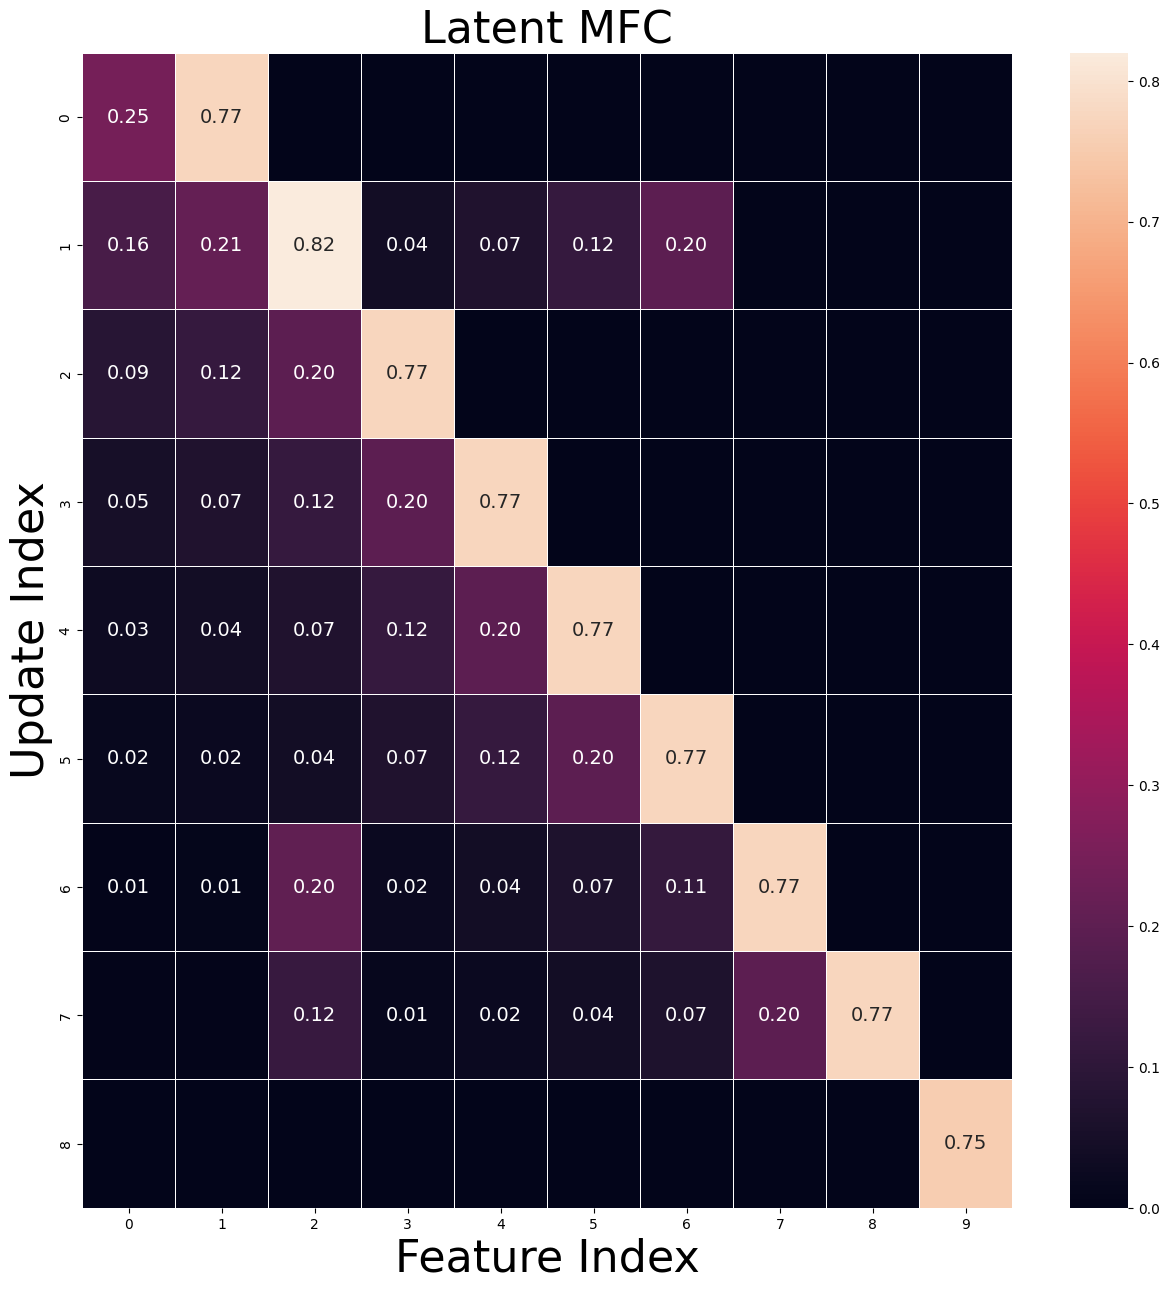

In [13]:
model_create_fn = InstanceCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(latent_mfc(model), title="Latent MFC")

## Latent Mcf

In [14]:
def latent_mcf(model):
    _latent_mcf = np.zeros((model.mcf.input_size, model.mcf.output_size))
    context_units = np.eye(model.mcf.input_size, model.mcf.input_size)
    for i in range(model.mcf.input_size):
        _latent_mcf[i] = model.mcf.probe(context_units[i])
    return _latent_mcf


<Axes: title={'center': 'Latent MCF'}, xlabel='Feature Index', ylabel='Update Index'>

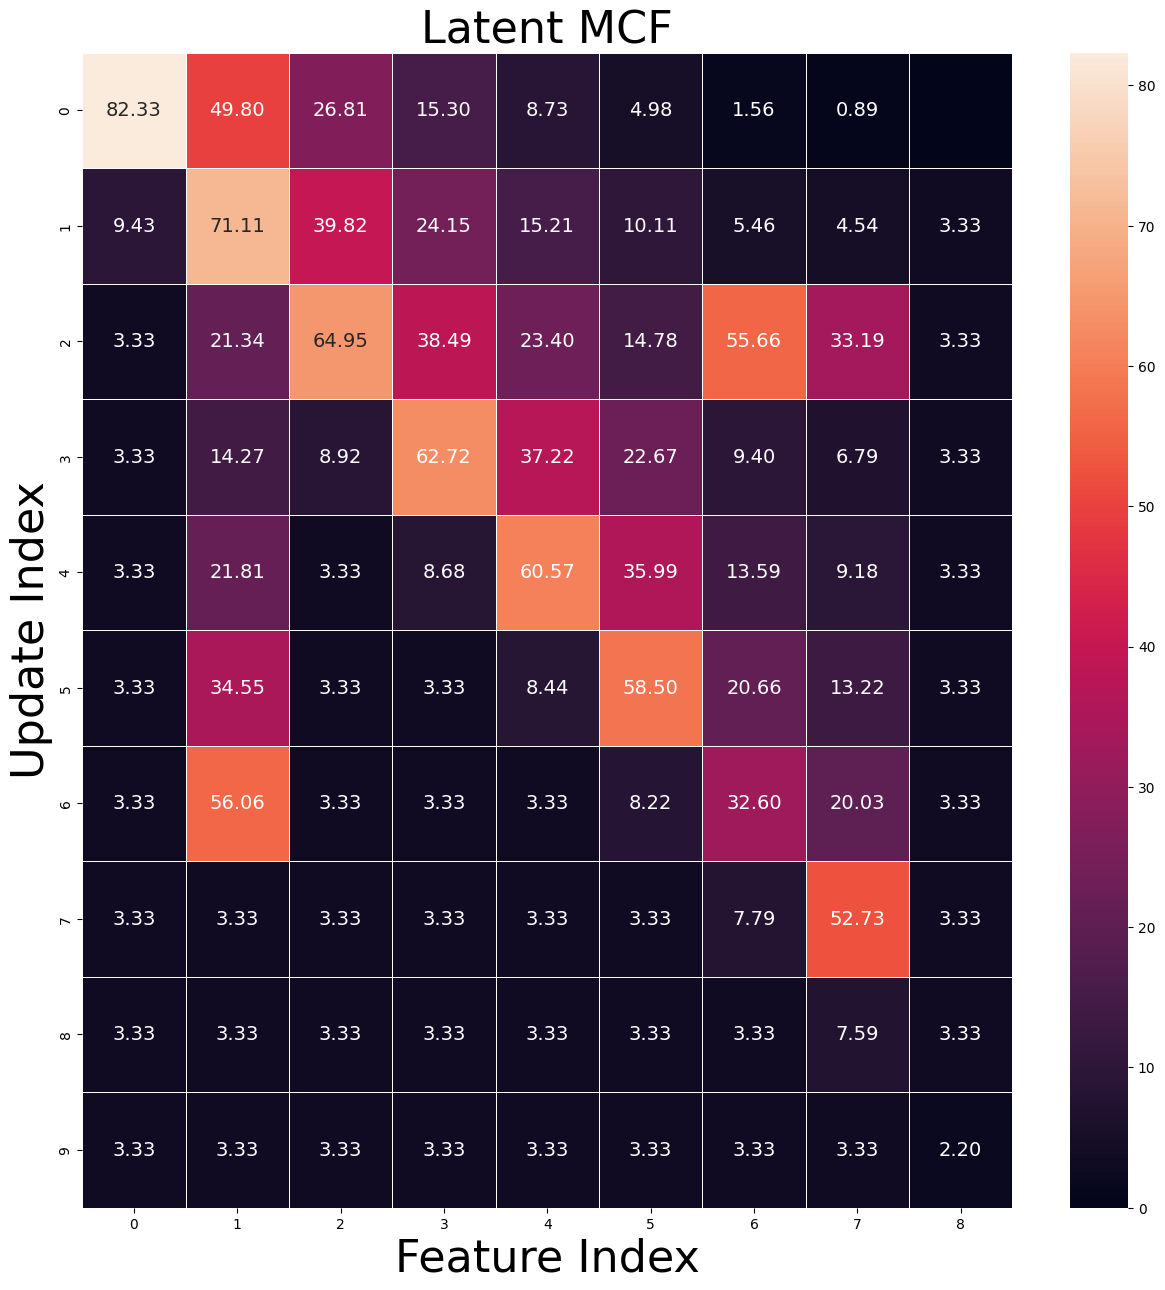

In [15]:
model_create_fn = InstanceCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(latent_mcf(model), title="Latent MCF")

## Latent Mff
By passing item representations through F->C memory and the outputs of the F->C memory through the C->F memory, we can produce a singular matrix of F->F associations in a matter agnostic to the underlying architecture.

MFF represents the associations between items in the memory, and can be used to predict how retrieving an item will shift support for retrieving other items.

In [16]:
def latent_mff(model):
    _latent_mff = np.zeros((model.item_count, model.item_count))
    _latent_mfc = latent_mfc(model)
    for i in range(model.item_count):
        _latent_mff[i] = model.mcf.probe(_latent_mfc[i])
    return _latent_mff

<Axes: title={'center': 'Latent MFF'}, xlabel='Feature Index', ylabel='Update Index'>

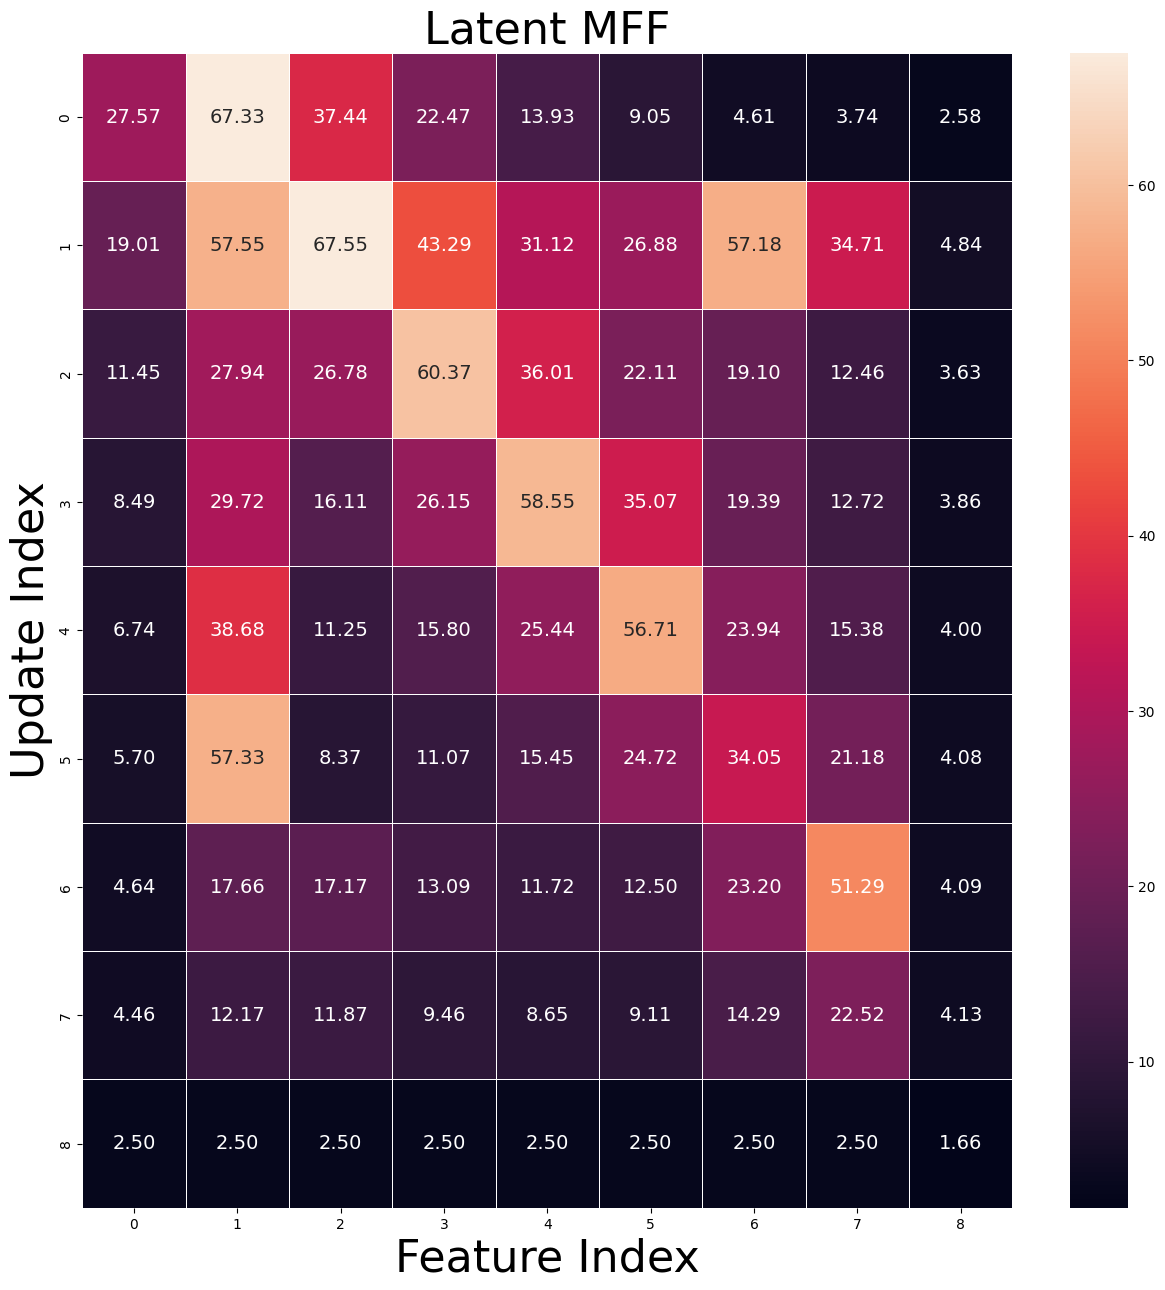

In [17]:
model_create_fn = InstanceCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(latent_mff(model), title="Latent MFF")

<Axes: title={'center': 'Latent MFF'}, xlabel='Feature Index', ylabel='Update Index'>

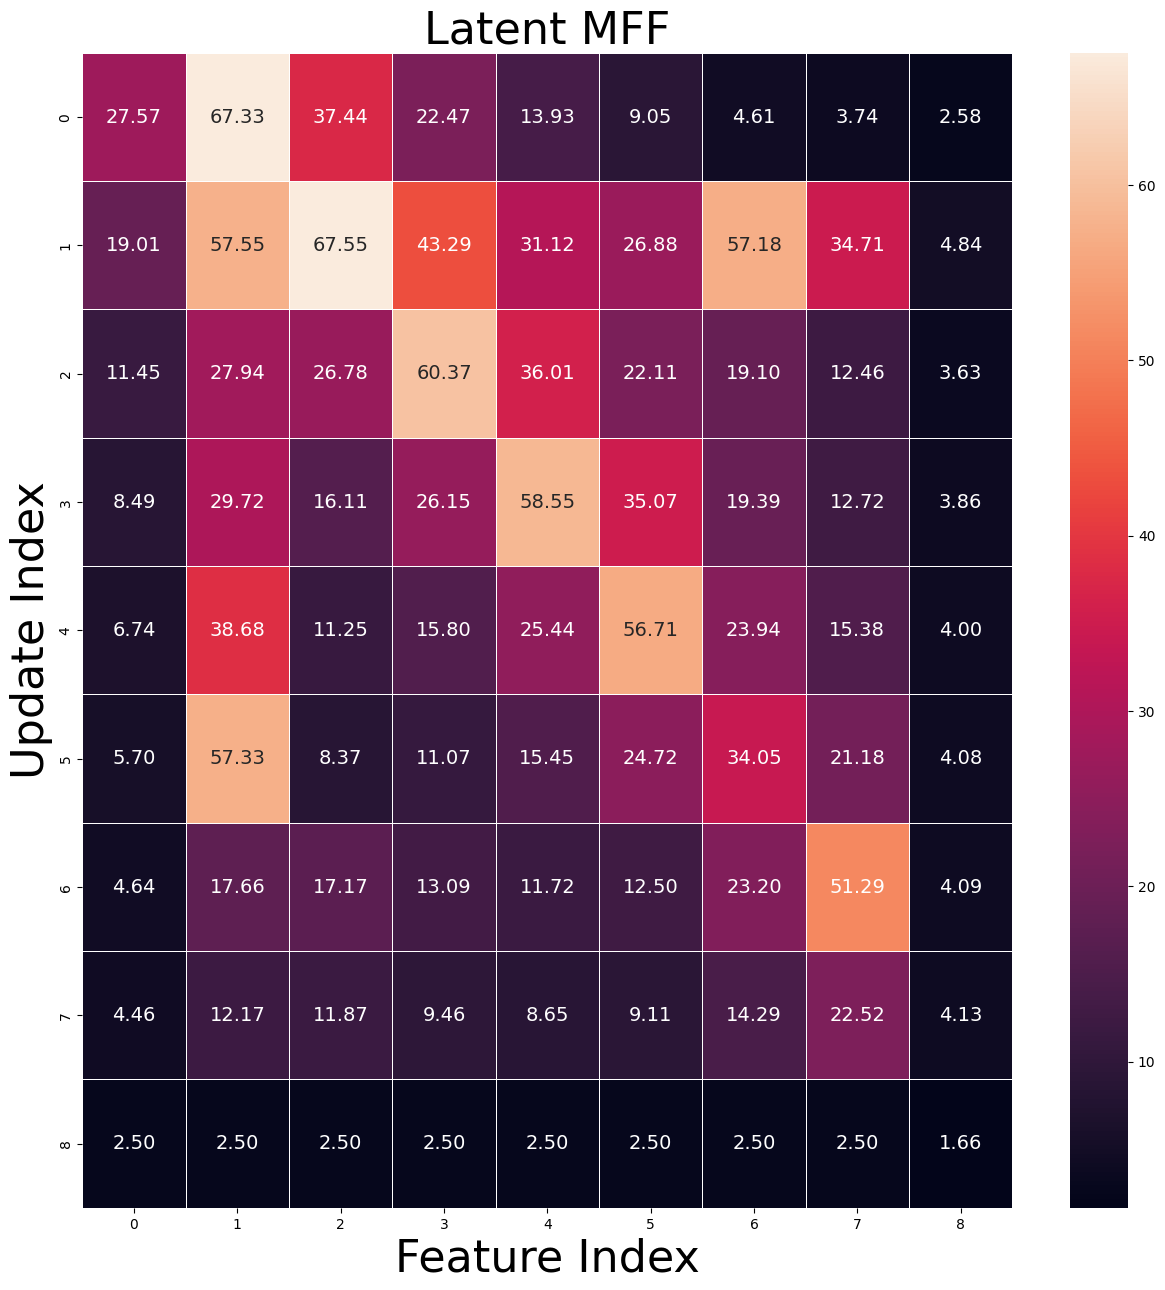

In [18]:
model_create_fn = BaseCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(latent_mff(model), title="Latent MFF")

## Memory Connectivity by Lag

To better understand our connectivity matrices, we can visualize the connectivity of the memory as a function of key variables such as the serial lag between items.

In [19]:
def connectivity_by_lag(item_connections, item_count):
    "Check out `mixed_connectivity_by_lag` for an implementation that handles flexible study order"

    lag_range = item_count - 1
    total_connectivity = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    item_positions = np.arange(item_count, dtype=int)

    # tabulate bin totals for actual and possible lags
    # this time instead of looping through trials and recall indices, we only loop once through each item index
    for i in range(item_count):
        # lag of each item from current item is item position - i,
        # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
        item_lags = item_positions - i + lag_range
        total_connectivity[item_lags] += item_connections[i]
        total_possible_lags[item_lags] += 1

    # divide by possible lags to get average connectivity
    return total_connectivity / total_possible_lags

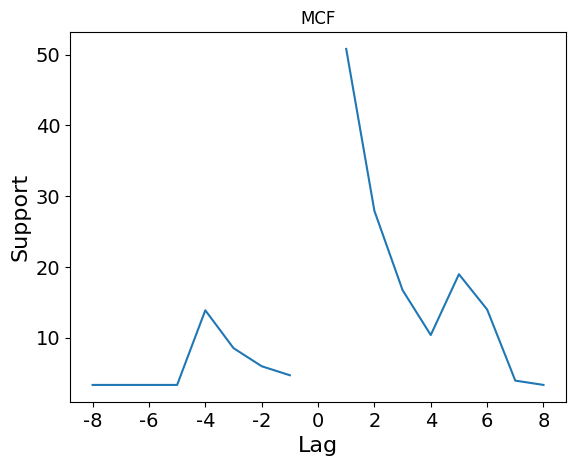

Text(0, 0.5, 'Support')

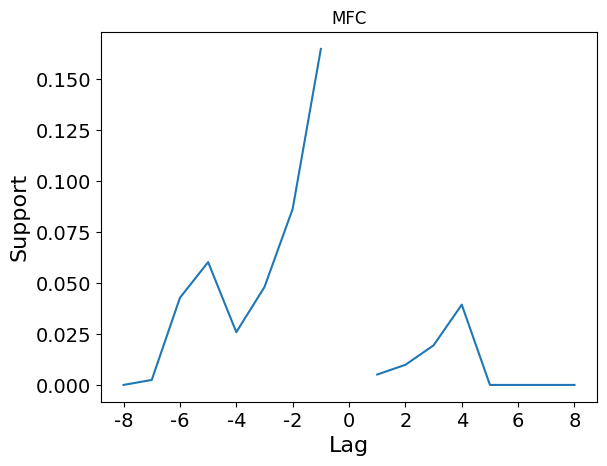

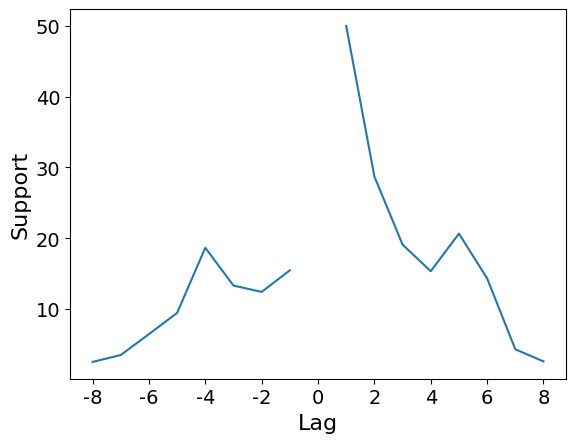

In [20]:
model_create_fn = BaseCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_crp = connectivity_by_lag(mcf[1:, :], model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
axis.set_title("MCF")
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_crp = connectivity_by_lag(mfc[:, 1:], model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
axis.set_title("MFC")
# fig.suptitle('PrototypeCMR Item Connectivity By Lag');

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
test_crp = connectivity_by_lag(mff, model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
# axis.set_title('MFF');

Minus-lag transitions are supported by MFC connections plus its transformation of the contextual probe to target minus-lag items. Plus-lag transitions are supported by MCF connections, especially connections between the last recalled item and its primary pre-experimental contextual unit, which is reliably activated via MFC context reinstatement.

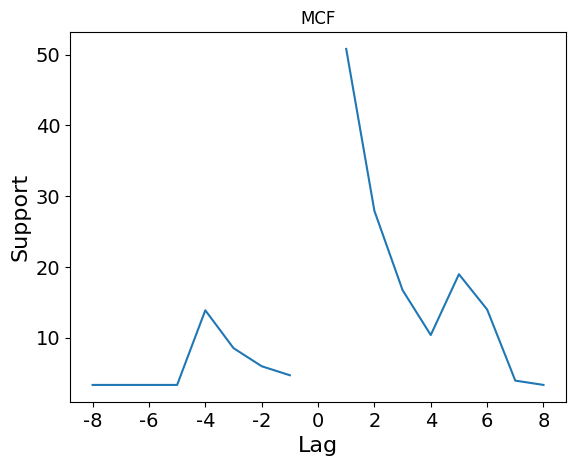

Text(0, 0.5, 'Support')

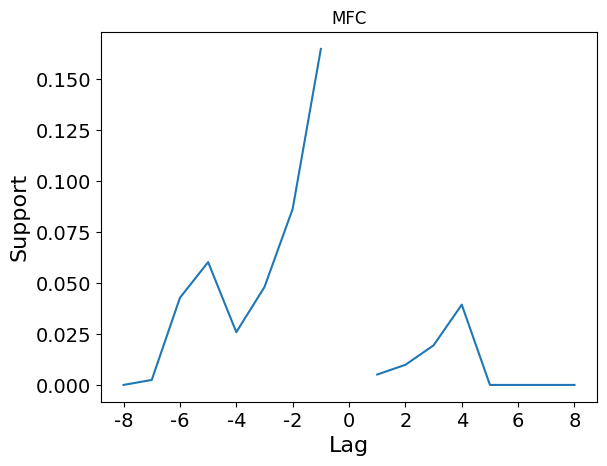

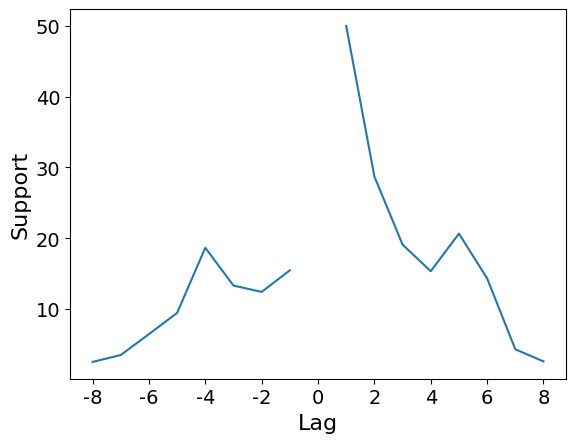

In [21]:
model_create_fn = InstanceCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_crp = connectivity_by_lag(mcf[1:, :], model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
axis.set_title("MCF")
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_crp = connectivity_by_lag(mfc[:, 1:], model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
axis.set_title("MFC")
# fig.suptitle('PrototypeCMR Item Connectivity By Lag');

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
test_crp = connectivity_by_lag(mff, model.item_count)
test_crp[model.item_count - 1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 2))
axis.set_xticklabels(np.arange(0, len(test_crp), 2) - (model.item_count - 1))
axis.tick_params(labelsize=14)
axis.set_xlabel(axis.get_xlabel(), fontsize=16)
axis.set_ylabel(axis.get_ylabel(), fontsize=16)
axis.set_xlabel("Lag", fontsize=16)
axis.set_ylabel("Support", fontsize=16)
# axis.set_title('MFF');

## Memory Connectivity by Serial Position

This is less interpretable. Maybe implemented incorrectly?

In [22]:
def connectivity_by_study_position(item_connections, item_count):
    "Check out `mixed_connectivity_by_lag` for an implementation that handles flexible study order"

    total_connectivity = np.zeros(item_count)

    # tabulate bin totals for actual and possible lags
    # this time instead of looping through trials and recall indices, we only loop once through each item index
    for i in range(item_count):
        # lag of each item from current item is item position - i,
        # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
        self_connection = np.zeros(item_count)
        self_connection[i] = item_connections[i, i]
        total_connectivity += item_connections[i] - self_connection

    # divide by possible lags to get average connectivity
    return total_connectivity

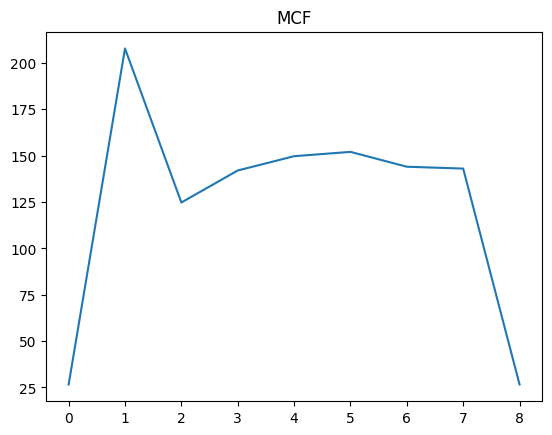

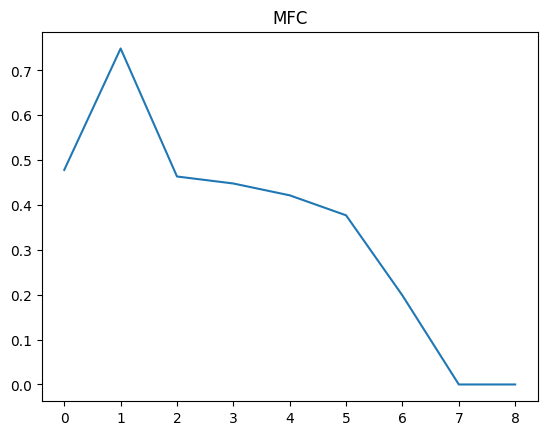

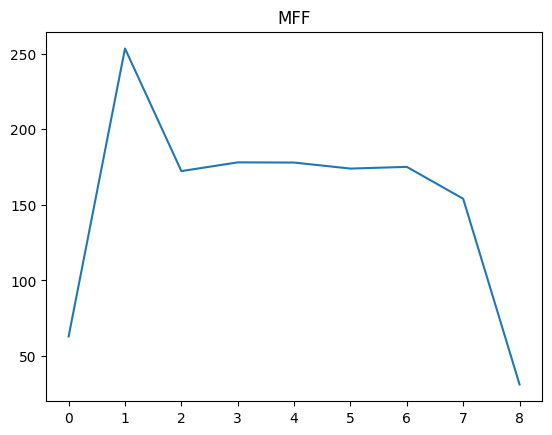

In [23]:
model_create_fn = BaseCMR
list_length = 9
item_count = 8
parameters = base_params

present = jnp.array([1, 2, 3, 4, 5, 6, 2, 7, 8])
model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_spc = connectivity_by_study_position(mcf[1:, :], model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title("MCF")
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_spc = connectivity_by_study_position(mfc[:, 1:], model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title("MFC")
# fig.suptitle('PrototypeCMR Item Connectivity By Study Position');
plt.show()

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)  # , figsize=(15/2, 15/2), sharey=True)
test_spc = connectivity_by_study_position(mff, model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title("MFF")
# fig.suptitle('PrototypeCMR Item Connectivity By Study Position');
plt.show()